In [1]:
import os

In [2]:
TOP = os.getcwd().replace('notebooks','')
processed_dir = TOP + 'data/processed/'
external_dir = TOP + 'data/external/'
interim_dir = TOP + 'data/interim/'
figures_dir = TOP + 'reports/figures/'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
%matplotlib inline

In [4]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors


In [15]:
vega2= pd.read_csv(interim_dir+'vega_weighted_091124.csv')

In [7]:
df = pd.read_excel(interim_dir+'categorisatons_wscreening_constraints_final_picks_080823.xlsx', sheet_name = 'All data', index_col = [0])
mydict = {k:v for k,v in zip(df['dtxsid'],df[ 'group_str'])}
selections = {k:v for k,v in zip(df['dtxsid'],df[ 'final_picks']) }

In [13]:
smidict = {k:v for k,v in zip(df['dtxsid'],df[ 'smiles'])}

In [16]:
vega_1 = (vega2.reset_index()
 .assign(group_str = vega2.reset_index()['dtxsid'].replace(mydict ))
 )

In [17]:
vega_1 = (vega_1.assign(final_picks = vega_1['dtxsid'].replace(selections)))
vega_1 = (vega_1.assign(smiles = vega_1['dtxsid'].replace(smidict)))

In [21]:
vega_picks = (vega_1
 .set_index('dtxsid')
 .drop(['index'], axis = 1)
 .query('final_picks ==1')
)

In [22]:
import sys

In [23]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)



In [24]:
from model_functions import *

In [26]:
FO = mk_fp(vega_picks.reset_index())

In [34]:
#FO

In [28]:
ss = pd.read_csv(external_dir+'dataset_SKIN_CAESAR.txt', sep = '\t')

In [33]:
ss1 = (ss
 .rename(columns = {'CAS': 'dtxsid', 'SMILES': 'smiles'})
 .pipe(mk_fp)
)

In [35]:
FO['source'] = 'nccrp'
ss1['source'] = 'vega'

In [73]:
mut = pd.read_csv(external_dir+'dataset_MUTA_CAESAR.txt', sep = '\t')

In [74]:
mut1 = (mut
 .rename(columns = {'CAS': 'dtxsid', 'SMILES': 'smiles'})
 .pipe(mk_fp)
)

In [75]:
mut1['source'] = 'vega'

In [40]:
umap_df = pd.concat([FO, ss1])

In [41]:
import umap
import random

In [42]:
model = umap.UMAP(random_state=42, n_jobs = 1)

In [45]:
umap_features = model.fit_transform(umap_df.iloc[:,:-1])

In [46]:
umap_features = pd.DataFrame(umap_features, index = umap_df.index, columns = ['umap_x', 'umap_y'])

In [50]:
umap_features = pd.concat([umap_features, umap_df['source']], axis =1)

In [58]:
ss_pred = {k:v for k,v in zip(vega_picks.index, vega_picks['Skin Sensitization model (CAESAR)-assessment'])}

In [78]:
mut_pred = {k:v for k,v in zip(vega_picks.index, vega_picks['ames_mutagenicity'])}



In [110]:
umap_df2 = pd.concat([FO, mut1])

In [111]:
#umap_df2

In [112]:
umap_features1 = model.fit_transform(umap_df2.iloc[:,:-1])

In [113]:
umap_features1 =pd.DataFrame(umap_features1, index = umap_df2.index, columns = ['umap_x', 'umap_y'])
umap_features1 = pd.concat([umap_features1, umap_df2['source']], axis =1)

In [114]:
umap_features1 = (umap_features1.reset_index()
 .rename(columns = {'index':'dtxsid'})
 .assign(mut_pred=lambda df: df['dtxsid'].map(lambda x: ss_pred.get(x, np.nan)))
)

In [117]:
#umap_features1

In [66]:
umap_features = (umap_features.reset_index()
 .rename(columns = {'index':'dtxsid'})
 .assign(ss_pred=lambda df: df['dtxsid'].map(lambda x: ss_pred.get(x, np.nan)))
)

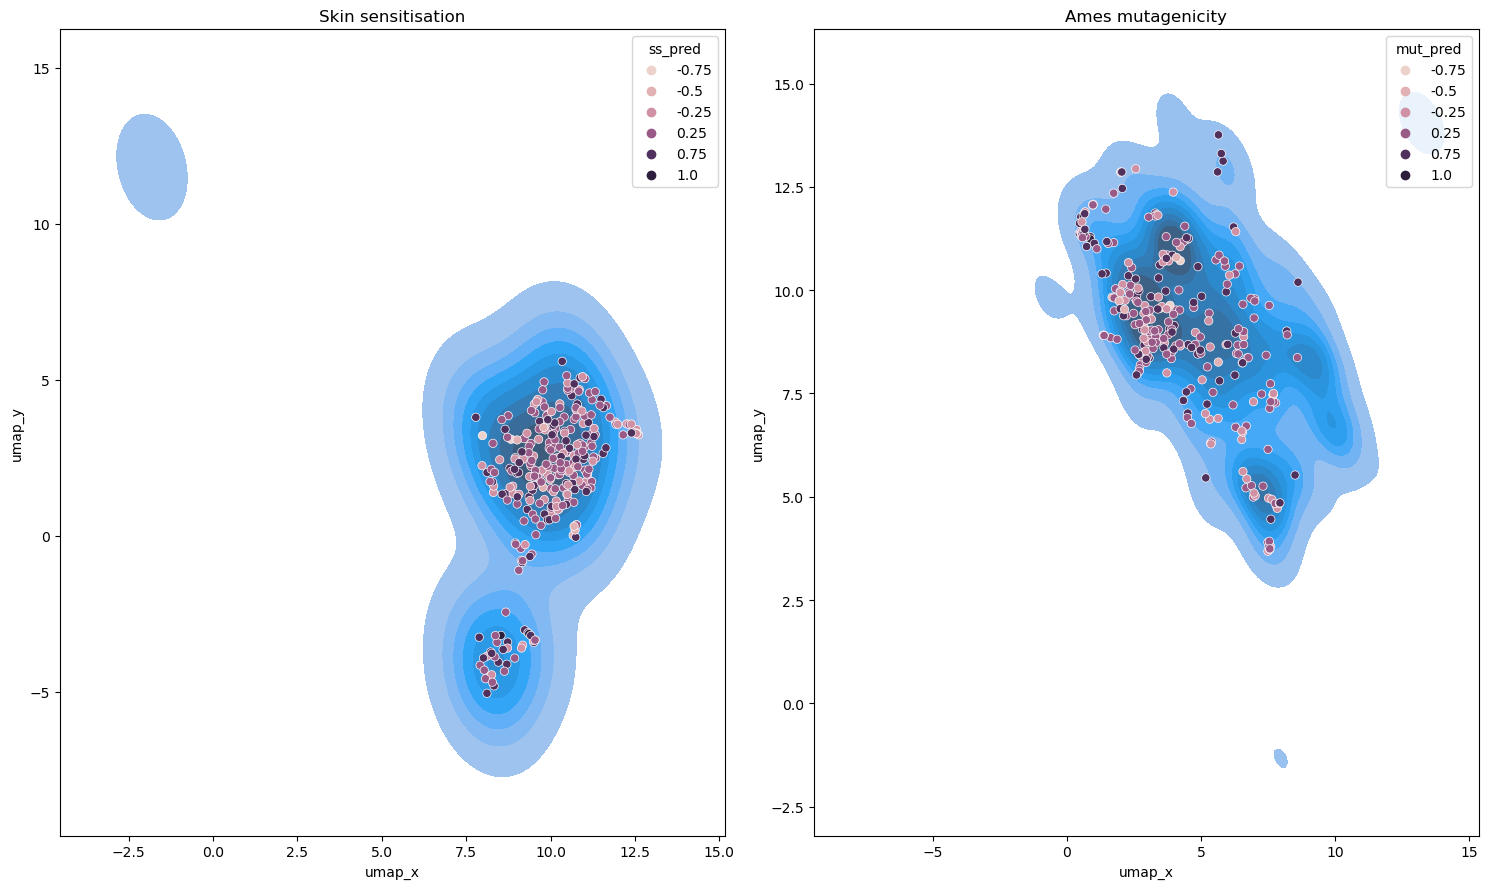

In [119]:
fig, (ax,ax1)= plt.subplots(1,2, figsize = (15,9))

ax.title.set_text('Skin sensitisation')
ax1.title.set_text('Ames mutagenicity')


sns.kdeplot(x="umap_x", y="umap_y", fill = True, data=umap_features[umap_features['source'] =='vega'], ax = ax)


sns.scatterplot(x="umap_x", y="umap_y", hue = 'ss_pred', 
                data=umap_features, ax=ax)

sns.kdeplot(x="umap_x", y="umap_y", fill = True,
                     data=umap_features1[umap_features1['source'] =='vega'], ax =ax1)

sns.scatterplot(x="umap_x", y="umap_y", hue = 'mut_pred', data=umap_features1, ax=ax1)
plt.tight_layout()
fig.savefig(figures_dir+'figs11.png', dpi = 300)